# Neo4j contributors prediction

The goal of our project is to determine whether a given GitHub user within our dataset contributed to a repository owned by the Neo4j organiszation.

## Requirements

- matplotlib
- seaborn >= 0.10.0
- pandas >= 1.0

In [1]:
from distutils.version import LooseVersion

# plotting packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# dataframe management
import pandas as pd

In [2]:
sns_min_version = "0.10.0"
assert \
    LooseVersion(sns.__version__) >= LooseVersion(sns_min_version), \
    "Your version of seaborn is too old, you may encounter plotting issues in the rest of this notebook. " \
    "Try upgrading to at least " + sns_min_version

In [3]:
# increase default fig and font size for matplotlib
plt.rcParams["figure.figsize"] = (15, 8)
plt.rcParams["font.size"] = 14

## Data exploration


In [4]:
data = pd.read_csv("../data/data_ch8.csv")
data.head()

,user_id,followers,publicRepos,contributed_to_neo4j
0,1,0.0,34.0,False
1,31,148.0,27.0,False
2,32,594.0,217.0,True
3,33,29.0,66.0,False
4,34,17.0,22.0,False


## Feature visualization

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               596 non-null    int64  
 1   followers             594 non-null    float64
 2   publicRepos           594 non-null    float64
 3   contributed_to_neo4j  596 non-null    bool   
dtypes: bool(1), float64(2), int64(1)
memory usage: 14.7 KB


In [6]:
data.describe()

,user_id,followers,publicRepos
count,596.000000,594.000000,594.000000
mean,3025.988255,93.457912,90.321549
std,5333.331601,525.309949,547.851252
min,1.000000,0.000000,0.000000
25%,188.750000,5.000000,11.000000
50%,337.500000,21.000000,28.000000
75%,486.250000,61.750000,63.750000
max,14599.000000,11644.000000,12670.000000


In [7]:
data.describe(include='bool')

,contributed_to_neo4j
count,596
unique,2
top,False
freq,427


In [8]:
data.contributed_to_neo4j.value_counts()

False    427
True     169
Name: contributed_to_neo4j, dtype: int64

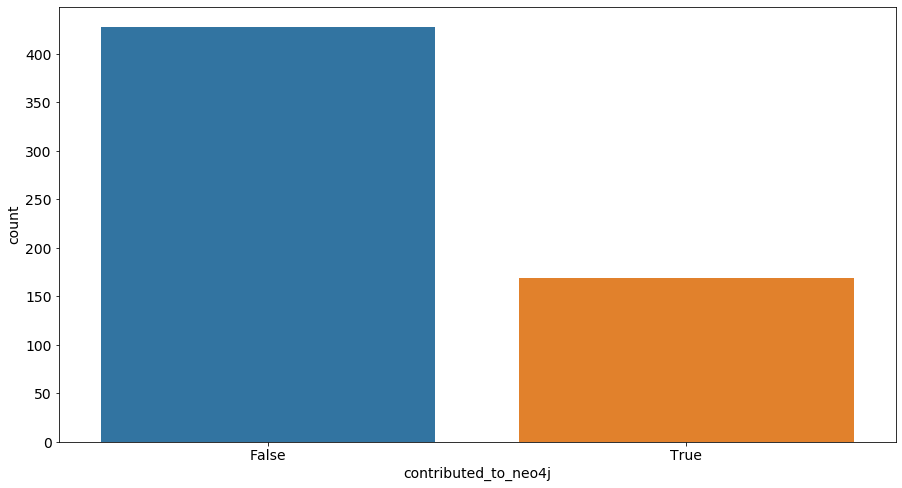

In [9]:
sns.countplot(x="contributed_to_neo4j", data=data)
# plt.savefig("label_distribution.png")

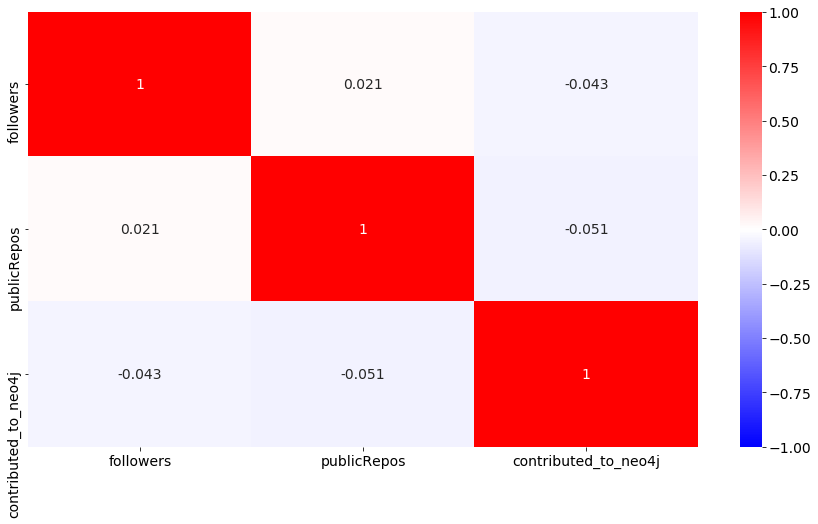

In [10]:
df = data.drop("user_id", axis=1)
sns.heatmap(df.corr(), cmap="bwr", vmin=-1, vmax=1, annot=True);

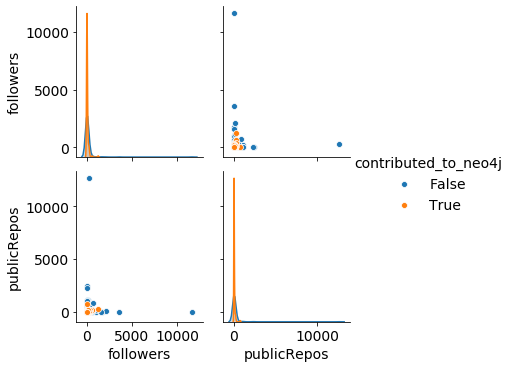

In [11]:
sns.pairplot(data, vars=("followers", "publicRepos"), hue="contributed_to_neo4j");

## Feature engineering

### Data cleaning

In [12]:
# let's quickly drop some outliers by clipping the values to some realistic values
data["publicRepos"] = data.publicRepos.clip(upper=100)
data["followers"] = data.followers.clip(upper=100)

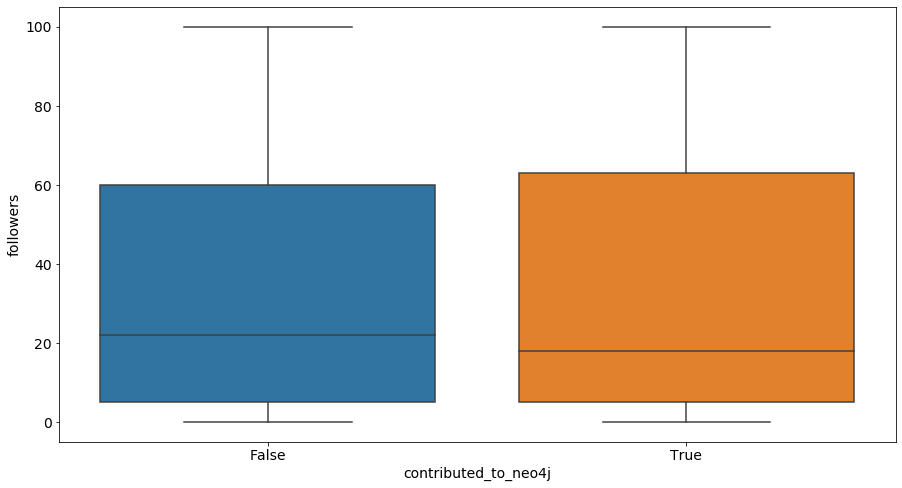

In [13]:
sns.boxplot(x="contributed_to_neo4j",y="followers",data=data);

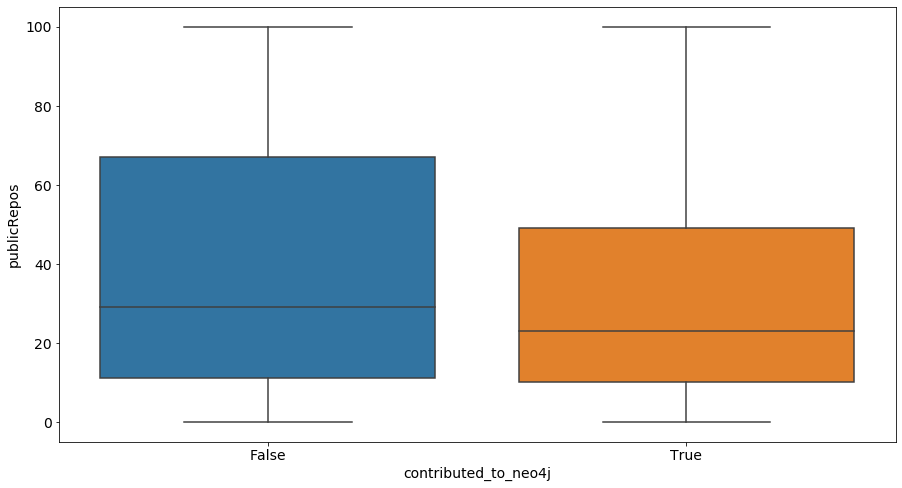

In [14]:
sns.boxplot(x="contributed_to_neo4j",y="publicRepos",data=data);

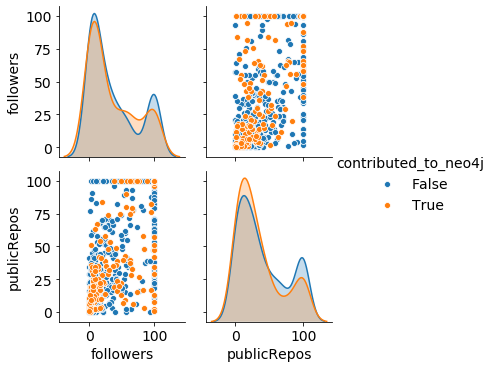

In [15]:
sns.pairplot(data, vars=("followers", "publicRepos"), hue="contributed_to_neo4j", dropna=True);

## Test / train split

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [17]:
features = ["followers", "publicRepos"]

y = data.contributed_to_neo4j
X = data[features]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, 
    random_state=123,
    stratify=y
)
len(X_train), len(X_test)

(417, 179)

In [19]:
imp = SimpleImputer(strategy='mean')
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

## Model building

In [20]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
clf = DecisionTreeClassifier(random_state=123, min_samples_leaf=10)

In [22]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

## Result analysis

First, let's check the feature importance:

In [23]:
print("\n".join(
    [f"{feat}: {imp:2.3f}" for feat, imp in zip(features, clf.feature_importances_)]
))

followers: 0.412
publicRepos: 0.588


In [24]:
# draw the Decision Tree
# from sklearn.tree import plot_tree
# plot_tree(clf, class_names=["True", "False"], filled=True, feature_names=features);
# plt.savefig("dt_1.png")

## Model evaluation

In [25]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [26]:
y_pred = clf.predict(X_test)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.72      0.85      0.78       128
        True       0.32      0.18      0.23        51

    accuracy                           0.66       179
   macro avg       0.52      0.51      0.50       179
weighted avg       0.61      0.66      0.62       179



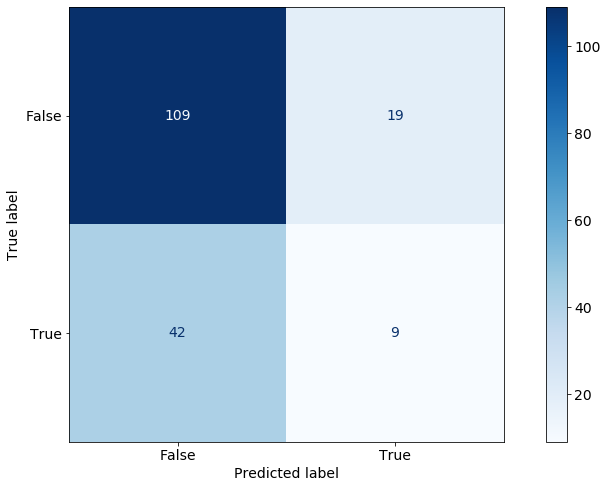

In [28]:
plot_confusion_matrix(
    clf, X_test, y_test,
    cmap=plt.cm.Blues,
    values_format="d"
);